In [7]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier

### Helper functions

In [8]:
def conf_int(num_array):
    """
    Return the 2.5% and 97.5% confidence interval from numpy array as string.
    
    Parameters
    ----------
    num_array : numpy array

    Returns
    -------
    str
        2.5% - 97.5% confidence interval

    """
    ci = st.t.interval(confidence=0.95, df=len(num_array)-1,
                        loc=np.nanmean(num_array),
                        scale=st.sem(num_array, nan_policy='omit'))

    return(f'{ci[0]:.5f}-{ci[1]:.5f}')


def merge_scores(list_with_scores):
    """
    Merge scores from cross-validation into one score dictionary.

    Parameters
    ----------
    list_with_scores : list
        contains two or more crossvalidation scores
    
    Returns
    -------
    dict
        dictionary with merged scores
    """

    for i in range(1,len(list_with_scores)):
        for k in list_with_scores[0].keys():
            list_with_scores[0][k] = np.concatenate((list_with_scores[0][k], list_with_scores[i][k]), axis=0)

    return list_with_scores[0]

### Loading the file with features

In [15]:
dataset = pd.read_csv("../data/features.csv")
X = dataset.iloc[:,4:-1]
y = dataset.iloc[:,-1]

## Preprocessing

In [16]:
# removing the columns with missing values
X = X.dropna(axis=1)
# adding the performed activities and imaging session number as dummy variable
X = pd.concat([X, pd.get_dummies(dataset.iloc[:,3], drop_first=True), pd.get_dummies(dataset.iloc[:,2], prefix="rep_", drop_first=True)], axis=1)

# Saving the column names
col_names = X.columns

# convert to numpy arrays
X, y = np.array(X), np.array(y)

# Standardization with standard scaler
standard_scaler = StandardScaler()
norm_X = standard_scaler.fit_transform(X)

## Training the machine learning model

In [11]:
# Constants used for training
NUM_TRIALS = 10
K_FOLD = 10
N_JOBS = -1

In [13]:
# Random Forest
rf = RandomForestClassifier()

# parameter grid for GridSearchCV
p_grid = {
    'n_estimators': [1000],
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': [50, 100, None],
    'max_features': ["sqrt", "log2"]
}

nested_scores = []

count = 0
for i in range(NUM_TRIALS):
    inner_cv = KFold(n_splits=K_FOLD, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=K_FOLD, shuffle=True, random_state=i*10)

    clf = GridSearchCV(estimator=rf, param_grid=p_grid, scoring="roc_auc", cv=inner_cv, n_jobs=N_JOBS)
    nested_cv = cross_validate(estimator=clf, scoring="roc_auc", X=norm_X, y=y, n_jobs=N_JOBS, cv=outer_cv, return_estimator=True)

    count += 1
    print(f"RF Trial {count}/{NUM_TRIALS}")
    nested_scores.append(nested_cv)

nested_scores = merge_scores(nested_scores)


RF Trial 1/10


Extracting the feature importances from the best estimator in each cross validation

In [19]:
df_dict = {'features': col_names}
df_dict.update({f'cv_{i+1}_importances':nested_scores["estimator"][i].best_estimator_.feature_importances_ for i in range(len(nested_scores["estimator"]))})
df = pd.DataFrame(df_dict)
df

,features,cv_1_importances,cv_2_importances,cv_3_importances,cv_4_importances,cv_5_importances
0,blue_layer_value_mean,0.003154,0.002955,0.004136,0.003231,0.003342
1,blue_layer_value_mean_hsegment_1/10,0.004269,0.003831,0.003633,0.004714,0.003763
2,blue_layer_value_mean_hsegment_10/10,0.003987,0.003588,0.003605,0.004519,0.003380
3,blue_layer_value_mean_hsegment_2/10,0.004965,0.003983,0.004443,0.003704,0.004460
4,blue_layer_value_mean_hsegment_3/10,0.003917,0.002927,0.003161,0.003126,0.002709
...,...,...,...,...,...,...
318,sitting-levels-3.7_E,0.000105,0.000153,0.000158,0.000148,0.000138
319,sitting-levels-5_E,0.000205,0.000179,0.000158,0.000244,0.000159
320,sitting-levels-relaxstart_E,0.000240,0.000308,0.000220,0.000092,0.000187
321,rep__2,0.000168,0.000227,0.000271,0.000288,0.000148


Calculating row mean and standard deviation

In [20]:
df['rowsMean']=df.iloc[:,1:].mean(axis=1)
df['rowsStd']=df.iloc[:,1:].std(axis=1)

Sorting by mean feature importance and selecting the best 20 features

In [21]:
sorted_df = df.sort_values(by=['rowsMean'], ascending=False)
sorted_df[:20]

,features,cv_1_importances,cv_2_importances,cv_3_importances,cv_4_importances,cv_5_importances,rowsMean,rowsStd
23,blue_layer_value_sum_hsegment_1/10,0.012904,0.015524,0.012507,0.012113,0.010836,0.012777,0.001539
25,blue_layer_value_sum_hsegment_2/10,0.011435,0.010347,0.009724,0.009144,0.009433,0.010017,0.000813
276,red_layer_value_sum_hsegment_1/10,0.010489,0.009972,0.008377,0.009774,0.007972,0.009317,0.000970
142,gray_value_hsegment_9/10,0.006978,0.007939,0.007266,0.005302,0.008782,0.007253,0.001157
244,median_hsegment_10/10,0.005837,0.006119,0.008061,0.006794,0.007655,0.006893,0.000857
33,blue_pixels,0.005599,0.007155,0.006807,0.005321,0.008963,0.006769,0.001298
278,red_layer_value_sum_hsegment_2/10,0.007246,0.007401,0.006578,0.006467,0.005910,0.006720,0.000544
178,gray_value_min_hsegment_10/10,0.006153,0.005604,0.006596,0.006730,0.007961,0.006609,0.000782
24,blue_layer_value_sum_hsegment_10/10,0.008336,0.005617,0.006043,0.006571,0.005439,0.006401,0.001043
167,gray_value_median_hsegment_10/10,0.005519,0.006621,0.005141,0.006930,0.007181,0.006278,0.000804


Ploting the figure of the best 20 features and their Gini importance

/tmp/ipykernel_89695/521586882.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_features = sorted_df["features"][:NUM_FEATURES]
/tmp/ipykernel_89695/521586882.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.barh(y_pos, sorted_df['rowsMean'][:NUM_FEATURES], xerr=sorted_df['rowsStd'][:NUM_FEATURES], align='center')


Text(0.5, 0, 'Gini importance')

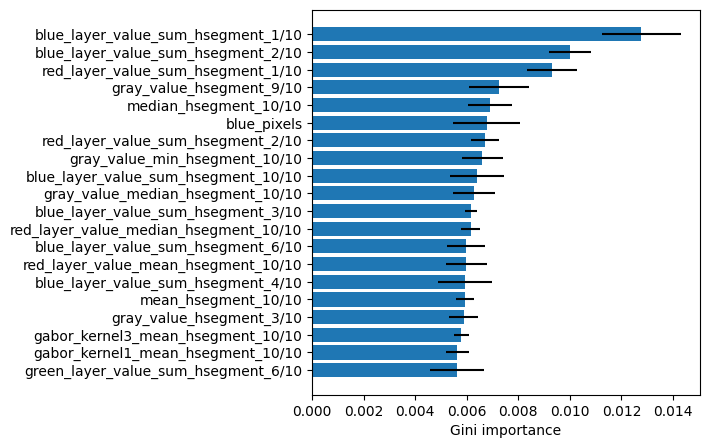

In [24]:
NUM_FEATURES = 20

top_features = sorted_df["features"][:NUM_FEATURES]


fig, ax = plt.subplots(figsize=(5,5))
y_pos = np.arange(NUM_FEATURES)

ax.barh(y_pos, sorted_df['rowsMean'][:NUM_FEATURES], xerr=sorted_df['rowsStd'][:NUM_FEATURES], align='center')
ax.set_yticks(y_pos, top_features)
ax.invert_yaxis()
ax.set_xlabel('Gini importance')